In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import check_random_state


In [22]:
# experiment parameters
n_datasets, n_train, n_test, sigma, k_plot = 100, 50, 1000, 0.32, 5

# seed to control randomness from a dedicated random state
base_rs = 0

In [23]:
def f_true(x):
    return np.sin(2 * np.pi * x)

In [ ]:
test_grid = np.linspace(0, 1, n_test)
true_vals = f_true(test_grid)

# store predictions from each model
predictions = {
    "Decision Tree": np.zeros((n_datasets, n_test)),
    "Random Forest": np.zeros((n_datasets, n_test)),
    "Gradient Boosting": np.zeros((n_datasets, n_test))
}

# run independent datasets to get predictions
for run in range(n_datasets):

    rng = check_random_state(base_rs + 12000 + run)
    train_x = rng.rand(n_train)
    train_y = f_true(train_x) + rng.normal(0, sigma, size=n_train)

    train_x2d = train_x.reshape(-1, 1)
    test_x2d = test_grid.reshape(-1, 1)

    # use fresh estimator each time with a different seed for each run
    model_list = [
        ("Decision Tree", DecisionTreeRegressor(random_state=base_rs + (20000 + run))),
        ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=base_rs + (30000 + run), n_jobs=-1)),
        ("Gradient Boosting", GradientBoostingRegressor(n_estimators=100, random_state=base_rs + (40000 + run)))
    ]

    # fit each model and log predictions
    for name, model in model_list:
        model.fit(train_x2d, train_y)
        predictions[name][run] = model.predict(test_x2d)


# compute bias^2, variance, mse for each model
model_stats = {}
for name in predictions:

    preds = predictions[name]
    avg_curve = preds.mean(axis=0)

    bias_sq = np.mean((avg_curve - true_vals)**2)
    var_term = np.mean(preds.var(axis=0))
    mse_term = np.mean(np.mean((preds - true_vals)**2, axis=1))

    model_stats[name] = {
        "bias2": bias_sq,
        "variance": var_term,
        "mse": mse_term,
        "avg_pred": avg_curve,
        "preds": preds
    }

for name, st in model_stats.items():
    print(f"{name}:  bias^2={st['bias2']:.6f}   var={st['variance']:.6f}   mse={st['mse']:.6f}")


Decision Tree:  bias^2=0.001438   var=0.101747   mse=0.103185
Random Forest:  bias^2=0.001654   var=0.050647   mse=0.052302
Gradient Boosting:  bias^2=0.001245   var=0.076419   mse=0.077665


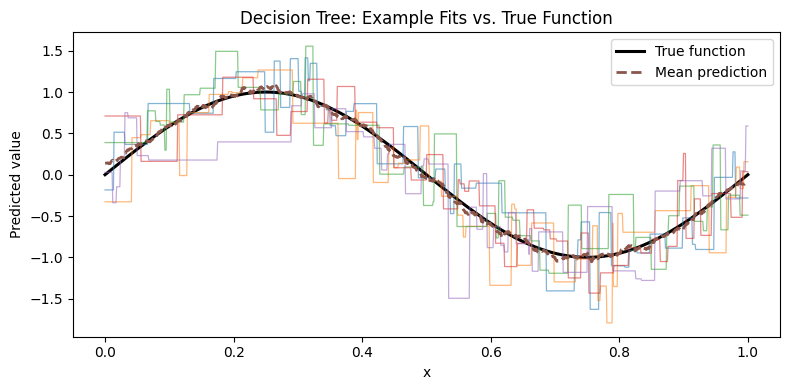

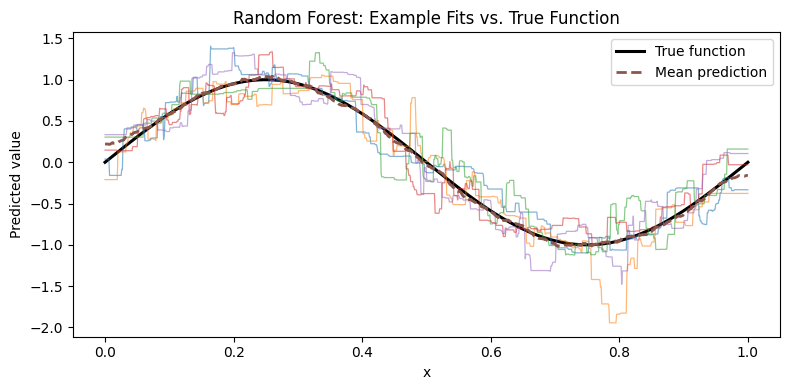

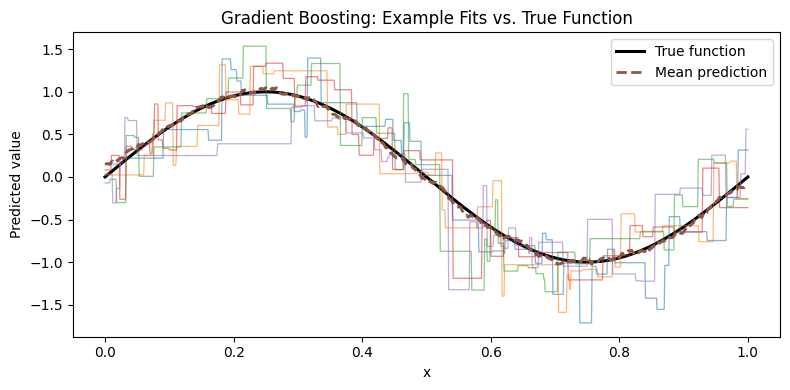

In [ ]:
# graph model predictions for each model
num_examples = 5  

for model_name, info in model_stats.items():
    plt.figure(figsize=(8, 4))

    plt.plot(test_grid, true_vals, linewidth=2.2,
             label="True function", color="black")

    sample_idxs = np.random.choice(n_datasets, size=num_examples, replace=False)
    for idx in sample_idxs:
        plt.plot(
            test_grid,
            info["preds"][idx],
            alpha=0.55,
            linewidth=0.9
        )

    plt.plot(
        test_grid,
        info["avg_pred"],
        linestyle="--",
        linewidth=2,
        label="Mean prediction",
    )

    plt.title(f"{model_name}: Example Fits vs. True Function")
    plt.xlabel("x")
    plt.ylabel("Predicted value")
    plt.legend()
    plt.tight_layout()
    plt.show()


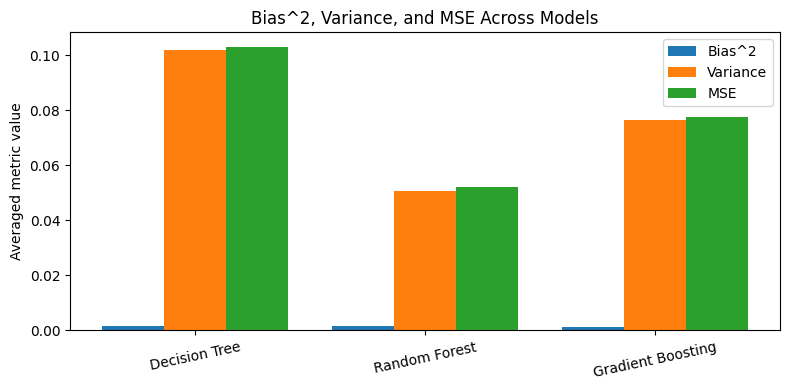

In [ ]:
# graph the comparison between model stats
model_order = list(model_stats.keys())

bias_vals = [model_stats[m]["bias2"] for m in model_order]
var_vals  = [model_stats[m]["variance"] for m in model_order]
mse_vals  = [model_stats[m]["mse"] for m in model_order]

x = np.arange(len(model_order))
bar_w = 0.27

plt.figure(figsize=(8, 4))
plt.bar(x - bar_w, bias_vals, width=bar_w, label="Bias^2")
plt.bar(x,         var_vals,  width=bar_w, label="Variance")
plt.bar(x + bar_w, mse_vals,  width=bar_w, label="MSE")

plt.xticks(x, model_order, rotation=12)
plt.ylabel("Averaged metric value")
plt.title("Bias^2, Variance, and MSE Across Models")
plt.legend()
plt.tight_layout()
plt.show()
